# Representations for Words, Phrases, Sentences

Downloading and installing the libraries necessary for the whole *task*

In [ ]:
!pip install datasets

In [ ]:
!pip install fasttext

In [ ]:
!pip install sentence-transformers

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import string
import numpy as np
from tqdm import tqdm
from gensim.models import Word2Vec
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import fasttext
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import random
from sklearn.ensemble import RandomForestClassifier

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Helper Functions

In [ ]:
# Preprocesses the brown corpus in Task (a)

def preprocess_brown(sentence):
    data_wo_punct = [x for x in sentence if x not in string.punctuation and x not in ["``","''"]]
    data_wo_singles = [x for x in data_wo_punct if x == "I" or len(x)>1]
    data_wo_num = [x for x in data_wo_singles if x.isalpha()]
    data_lower = [x.lower() for x in data_wo_num]
    data_wo_stop = [x for x in data_lower if x not in stop_words]

    return data_wo_stop


# Builds vocabulary, word-to-index and index-to-word dictionaries for a list of sentences

def vocab_ohe(sentence_list):

  #Adding unknown token for generating embediing for words in test set which are absent in the train corpu
  words = list(chain.from_iterable(sentence_list)) + ['<unk>']
  vocab = set(words)

  vocab_dict = {word:index for index,word in enumerate(vocab)}
  idx_dict = {index:word for index,word in enumerate(vocab)}

  return vocab, vocab_dict, idx_dict


# Builds skipgrams given a sentence and context window size

def create_skipgrams(sentence, window):
  word_context = []
  for i, word in enumerate(sentence):
        word_index = vocab_dict[word]
        context_index = [vocab_dict[elem] for elem in sentence[max(0, i - window):i] + sentence[i + 1:min(i + window + 1, len(sentence))]]
        for c_index in context_index:
          word_context_tuple = tuple(([word_index],[c_index]))
          word_context.append(word_context_tuple)

  return word_context


# Calculates cosine similarity between two word embeddings

def cosine_similarity(emb1, emb2):
    similarity = torch.dot(emb1, emb2) / (torch.norm(emb1) * torch.norm(emb2))

    return similarity.item()


# Reducing embedding dimensions from 50 to 2 for plotting

def create_plot(words, embeddings):
  pca = PCA(n_components=2)
  plot_embs = pca.fit_transform(embeddings)
  x, y = zip(*plot_embs)

  plt.figure(figsize=(8, 5))
  plt.scatter(x, y, color='blue')
  for i, word in enumerate(words):
      plt.annotate(word, (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='center')

  plt.title('Sample Word Embeddings Plot')
  plt.xlabel('Dim1 rep')
  plt.ylabel('Dim2 rep')
  plt.tight_layout()
  plt.show()


# Preprocess phrases and sentences in task (b)

def preprocess_sent(sentence):
    sent_list = sentence.strip().split(' ')
    data_wo_punct = [x for x in sent_list if x not in string.punctuation and x not in ["``","''"]]
    data_wo_singles = [x for x in data_wo_punct if x == "I" or len(x)>1]
    data_wo_num = [x for x in data_wo_singles if x.isalpha()]
    data_lower = [x.lower() for x in data_wo_num]
    data_wo_stop = [x for x in data_lower if x not in stop_words]
    data_final = ' '.join(data_wo_stop)
    return data_final


# Generates phrase and sentence embeddings using fasttext

def phrase_sent_embs(col, model):
  embs = [model.get_sentence_vector(elem) for elem in col]
  return embs

# Generates phrase and sentence embeddings using transformer model

def trans_emb(col, model):
  embs = [model.encode(sent, convert_to_tensor=True).detach().numpy() for sent in col]
  return embs

# Generates X_train, X_valid, X_test

def create_train_valid_test(df, col1, col2, model, ops = 'diff', emb='static'):

  if emb == 'static':
    sent1_emb, sent2_emb = phrase_sent_embs(df[col1], model), phrase_sent_embs(df[col2], model)

  else:
    sent1_emb, sent2_emb = trans_emb(df[col1], model), trans_emb(df[col2], model)

  sent_emb_all = list(zip(sent1_emb, sent2_emb))

  if ops == 'diff':
    X_train = [sent[0] - sent[1] for sent in sent_emb_all]

  elif ops == 'concat':
    X_train = [np.concatenate([sent[0], sent[1]]) for sent in sent_emb_all]

  elif ops == 'avg':
    X_train = [np.mean([sent[0], sent[1]]) for sent in sent_emb_all]

  return X_train

## Task (a): Word Similarity Scores

Given a pair of words, predict their similarity score. The
focus is how do you convert a word to its numerical representation, on which
learning algorithms (like Regression, classification etc) can be applied. Download
the dataset from this [link](https://). You have to come up with an unsupervised / semi
supervised method to achieve the task. Assume that you don't have any
supervised training data at your disposal. The whole dataset will be used as a
test set. Choose an appropriate metric that is suitable to assess the task and
report the results. You have to come up with a solution for the following
conditions:

--------------------------------------------------------------------------------------------------

(i) Constraints on Data Resources:
You can only use the following resources
(any one or all) to solve the problem:
- any monolingual English corpus - Maximum 1 million tokens.
- any curated/structured knowledge-bases / ontologies

In [ ]:
# Downloading brown corpus from nltk

from nltk.corpus import brown
nltk.download("brown")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

The reason for choosing the brown courpus lies in the fact that it contains sentences from various genres, not focusing on any particular domain. Although the total number of tokens cross the restriction of 1 million, it does so to a small extent. So, I did not take a subset of the dataset.

In [ ]:
# Data statistics of the brown corpus

data = brown.words()
data_sent = brown.sents()
print("Total number of tokens: ", len(data))
print("Total number of unique words in the corpus: ", len(np.unique(data)))
print("Total number of sentences in the courpus: ", len(data_sent))

Total number of tokens:  1161192
Total number of unique words in the corpus:  56057
Total number of sentences in the courpus:  57340


***Observation 1***:

Removing punctuations, single and number before case convertion reduces processing time to a large extent, since punctuations, single letters (except 'I') and numbers does not require case convertion to be omitted.


In [ ]:
# Preprocess sentences
# prep_sent: list of preprocessed sentences

prep_sent = []
for sentence in tqdm(data_sent):
    prep_sent.append(preprocess_brown(sentence))

100%|██████████| 57340/57340 [00:07<00:00, 8066.57it/s] 


***Remark***:

We are working with 'sentences' instead of 'words' here so as to capture the context of the words, which would be lost if we work with a single list of unique words.

In [ ]:
# vocab: list of unique words
# vocab_dict: word-to-index dictionary
# index_dict: index-to-word dictionary

vocab, vocab_dict, index_dict = vocab_ohe(prep_sent)

In [ ]:
# Building skipgrams with context window size 3
# skipgrams: list of bigrams of the form (target word, context word)

skipgrams = []
window = 3
for sentence in tqdm(prep_sent):
  skipgrams.extend(create_skipgrams(sentence, window))

100%|██████████| 57340/57340 [00:12<00:00, 4467.92it/s] 


In [ ]:
# Converting skipgrams to Pytorch tensors for modelling

target_words, context_words = zip(*skipgrams)
target_words = torch.LongTensor(target_words)
context_words = torch.LongTensor(context_words)





In this approach, we try to learn the context words, given the target words. In
other words, we try to maximize the probability of the context word occuring, given the target word.
*   nn.Embedding : Initilatizes every word with a random embedding.
*   Softmax : Activation function that converts scores to probabilities.
*   Binary Cross Entropy (BCE) Loss: Since the task is of binary classification (1 for context words and 0 for non-context words), BCE is used to calculate the difference between the class values and the generated probabilities.

The embedding size is chosen to be 50, for ease of computation. However, a larger embedding size like 100, 150, etc. could be used for better expressivity.

In [ ]:
# Training a neural network to generate embeddings of specifies size

vocab_size = len(vocab)
embedding_size = 50
embeddings = nn.Embedding(vocab_size, embedding_size)
softmax = nn.Softmax(dim=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(embeddings.parameters(), lr=0.01)
epochs = 200

epoch_list, loss_list = [], []

for epoch in tqdm(range(epochs)):

    optimizer.zero_grad()
    target_embedding, context_embedding = embeddings(target_words), embeddings(context_words)
    scores = torch.sum(target_embedding * context_embedding, dim=1)
    scores = softmax(scores)
    labels = torch.ones_like(scores)
    loss = criterion(scores, labels)
    epoch_list.append(epoch)
    loss_list.append(loss)
    print("Epoch {}-------------------------Loss {}".format(epoch, loss))
    loss.backward()
    optimizer.step()

torch.save(embeddings.state_dict(), '/content/drive/MyDrive/Precog/task1ai_model.pth')

In [ ]:
plt.plot(epoch_list, loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch/Loss plot')
plt.legend()
plt.show()

In [ ]:
# Loading the saved model

loaded_model = nn.Embedding(vocab_size, embedding_size)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Precog/task1ai_model.pth'))

<All keys matched successfully>

In [ ]:
# Loading the test data

test_data = pd.read_csv("/content/drive/MyDrive/Precog/SimLex-999.txt", sep = "\t", header = None)
test_data.columns = test_data.iloc[0]
test_data = test_data[1:]

word1_col = list(test_data['word1'])
word2_col = list(test_data['word2'])

In [ ]:
# Generate embeddings for the test set

word1_col_index = [vocab_dict[word] if word in vocab_dict else vocab_dict['<unk>'] for word in word1_col]
word2_col_index = [vocab_dict[word] if word in vocab_dict else vocab_dict['<unk>'] for word in word2_col]

word1_embs = loaded_model(torch.LongTensor(word1_col_index))
word2_embs = loaded_model(torch.LongTensor(word2_col_index))

In [ ]:
# Calculate and saving dataframn with cosine similarity between pairs of words

words = list(zip(word1_col, word2_col))
embs = list(zip(word1_embs, word2_embs))

similarities = []
for emb1,emb2 in embs:
    similarity = cosine_similarity(emb1.squeeze(), emb2.squeeze())
    similarities.append(round(similarity, 5))

sim_df = pd.DataFrame()
sim_df['word1'] = word1_col
sim_df['word2'] = word2_col
sim_df['cosine_similarity'] = similarities
sim_df.to_csv("/content/drive/MyDrive/Precog/cosine_sim_task1ai.csv")

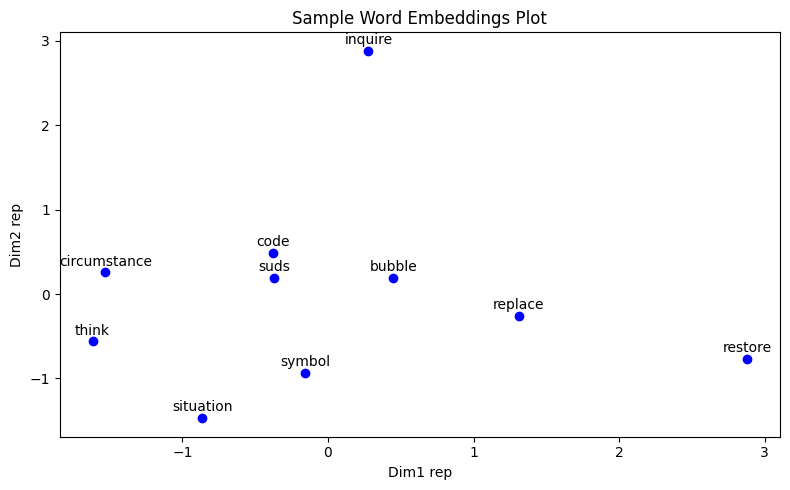

In [ ]:
# Generating scatter plot for sample words

sample_indices = random.sample(range(0, len(test_data) - 1), 5)
sample_words = list(np.array(word1_col)[sample_indices]) + list(np.array(word2_col)[sample_indices])

list1 = [embs.detach().numpy() for embs in word1_embs[sample_indices]]
list2 = [embs.detach().numpy() for embs in word2_embs[sample_indices]]
embeddings = list1 + list2

create_plot(sample_words, embeddings)

----------------------------------------------------------------------------------------------------------------------------------
(ii) Unconstrained : Consider that the constraints above are removed and you
are allowed to use any data or model.

In [ ]:
# Preparing sentences for fattext to process.

sent_for_ft = [' '.join(sent) for sent in prep_sent]

with open("/content/drive/MyDrive/Precog/brown_ft.txt", "w", encoding="utf-8") as f:
    for sent in sent_for_ft:
        f.write(sent + "\n")

I have chosen ***fasttext*** instead of ***word2vec*** mainly to handle out-of-vocabulary words. Since, fasttext utilizes sub-word information, it can generate embeddings for words that are not present in the training set.

In [ ]:
# Training the fasttext model on the brown corpus

fasttext_model = fasttext.train_unsupervised("/content/drive/MyDrive/Precog/brown_ft.txt", model='skipgram', dim=50, epoch=100)
fasttext_model.save_model("/content/drive/MyDrive/Precog/fasttext_model.bin")

In [ ]:
# Loading the trained model

fasttext_model = fasttext.load_model("/content/drive/MyDrive/Precog/fasttext_model.bin")

In [ ]:
# Generating word embeddings for the test data

w2v_col1, w2v_col2 = [],[]
for i in range(len(word1_col)):
  w2v_col1.append(fasttext_model.get_word_vector(word1_col[i]))
  w2v_col2.append(fasttext_model.get_word_vector(word2_col[i]))

In [ ]:
# Recording the cosine similarity between pairs of words

w2v_embs = list(zip(w2v_col1, w2v_col2))
similarities = []
for emb1,emb2 in w2v_embs:
    similarity = cosine_similarity(torch.tensor(emb1).squeeze(), torch.tensor(emb2).squeeze())
    similarities.append(round(similarity, 5))

sim_df = pd.DataFrame()
sim_df['word1'] = word1_col
sim_df['word2'] = word2_col
sim_df['cosine_similarity'] = similarities
sim_df.to_csv("/content/drive/MyDrive/Precog/cosine_sim_task1aii.csv")

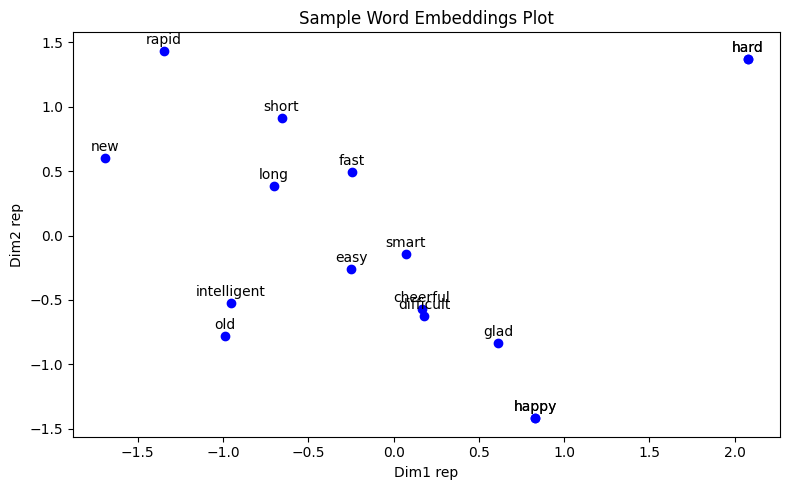

In [ ]:
# Generating scatter plot for sample words

sample_words = word1_col[sample_indices] + word2_col[sample_indices]
sample_embeddings = w2v_col1[sample_indices] + w2v_col2[sample_indices]

create_plot(sample_words, sample_embeddings)

## (b) Phrase and Sentence Similarity

In question (a) you would have come up with
a method to get numerical/vector representation given a word. Now you have to
come up with a mechanism to get representations for phrases and sentences.
How do you aggregate individual word representations to get phrase or sentence
embedding? You can use any pretrained static word embeddings like word2vec,
GLOVE, FASTTEXT etc, or create your own.

----------------------------------------------------------------------------------------------------------------

Phrase Similarity : Given a pair of phrases classify whether or not they
are similar. Dataset can be found [here](https://huggingface.co/datasets/PiC/phrase_similarity). Dataset has train/dev/test split.
You have to report results on the test set, and use train/dev sets as
needed.

In [ ]:
# Loading data from huggingface

data = load_dataset("PiC/phrase_similarity")
data.keys()

In [ ]:
type(data["train"])

In [ ]:
# Loading train, valid and test data as pandas dataframe.

phrase_train = data['train'].to_pandas()
phrase_valid = data['validation'].to_pandas()
phrase_test = data['test'].to_pandas()

In [ ]:
phrase_train.head()

,phrase1,phrase2,sentence1,sentence2,label,idx
0,newly formed camp,recently made encampment,newly formed camp is released from the membran...,recently made encampment is released from the ...,0,0
1,one data,a particular statistic,"According to one data, in 1910, on others – in...","According to a particular statistic, in 1910, ...",1,1
2,particular structure,specific edifice,Note that Fact 1 does not assume any particula...,Note that Fact 1 does not assume any specific ...,0,2
3,involved people,participating individuals,Assessment-Center are usually group-processes ...,Assessment-Center are usually group-processes ...,1,3
4,different cross,opposing inquiries,"At the end of the 1980s, a different cross had...","At the end of the 1980s, a opposing inquiries ...",0,4


In [ ]:
# Checking for class-imbalance

phrase_train['label'].value_counts(), phrase_valid['label'].value_counts()

(0    3502
 1    3502
 Name: label, dtype: int64,
 0    500
 1    500
 Name: label, dtype: int64)

The data is balanced!

In [ ]:
# Aggregating all the phrases for proprocessings.

all_phrases = list(phrase_train['phrase1']) + list(phrase_train['phrase2'])
all_phrases_prep = [preprocess_sent(phrase) for phrase in all_phrases]
all_phrases_prep

In [ ]:
with open("/content/drive/MyDrive/Precog/all_phrases.txt", "w", encoding="utf-8") as f:
    for phrase in all_phrases_prep:
        f.write(phrase + "\n")

In [ ]:
# Training fasttext model on the train data corpus

fasttext_phrase = fasttext.train_unsupervised("/content/drive/MyDrive/Precog/all_phrases.txt", model='skipgram', dim=50, epoch=100)
fasttext_phrase.save_model("/content/drive/MyDrive/Precog/fasttext_phrase.bin")

In [ ]:
fasttext_phrase = fasttext.load_model("/content/drive/MyDrive/Precog/fasttext_phrase.bin")

To capture the relation between the phrases, I have experimented with 3 kinds of embedding aggregation techniques:


*   Mean
*   Difference
*   Concatenation

All the three yield comparable results, but the best result is obtained from calculating the ***difference*** between the embeddings.



In [ ]:
X_train = create_train_valid_test(phrase_train, 'phrase1', 'phrase2', fasttext_phrase, 'diff','static')
X_valid = create_train_valid_test(phrase_valid, 'phrase1', 'phrase2', fasttext_phrase, 'diff','static')
X_test = create_train_valid_test(phrase_test, 'phrase1', 'phrase2', fasttext_phrase, 'diff','static')

In [ ]:
y_train = list(phrase_train['label'])
y_valid = list(phrase_valid['label'])
y_test = list(phrase_test['label'])

I had tried 3 kinds of classifers:
*   Logistic Regression
*   Random Forest Classifier
*   XGBoost Classifier


While Logistic Regression seemed to generalizd to the validation set, the other two seem to severly overfit the training data. Althought the accuracy is very low, fine tuning the model might better the case.

In [ ]:
model = LogisticRegression()
model.fit(np.array(X_train).reshape(-1,1), np.array(y_train))

LogisticRegression()

In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_valid).reshape(-1,1))
y_pred_train = model.predict(np.array(X_train).reshape(-1,1))

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy on Train Set: {accuracy_train:.4f}")
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Train Set: 0.5009
Accuracy on Validation Set: 0.4940


In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_test))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")


Accuracy on Test Set: 0.4920


-----------------------------------------------------------------------------------------------------

(ii) Sentence Similarity : Given a pair of sentences classify whether or not
they are similar. Dataset can be found [here](https://huggingface.co/datasets/paws). Dataset has train/dev/test
split. You have to report results on the test set. , and use train/dev sets as
needed.

In [ ]:
data = load_dataset("paws", "labeled_final")
data.keys()

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

dict_keys(['train', 'test', 'validation'])

In [ ]:
# Loading huggingface data to pandas dataframe

df_sent_train = data['train'].to_pandas()
df_sent_valid = data['validation'].to_pandas()
df_sent_test = data['test'].to_pandas()

In [ ]:
df_sent_train.head()

,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1


In [ ]:
# Checking for class imbalance

df_sent_train['label'].value_counts(), df_sent_valid['label'].value_counts()

(0    27572
 1    21829
 Name: label, dtype: int64,
 0    4461
 1    3539
 Name: label, dtype: int64)

In [ ]:
# Processing sentences to train the fasttext model

all_sents = list(df_sent_train['sentence1']) + list(df_sent_train['sentence2'])
all_sents_prep = [preprocess_sent(sent) for sent in all_sents]

In [ ]:
with open("/content/drive/MyDrive/Precog/all_sents.txt", "w", encoding="utf-8") as f:
    for sent in all_sents_prep:
        f.write(sent + "\n")

In [ ]:
# Training the fasttext model for sentence data

fasttext_sent = fasttext.train_unsupervised("/content/drive/MyDrive/Precog/all_sents.txt", model='skipgram', dim=50, epoch=100)
fasttext_sent.save_model("/content/drive/MyDrive/Precog/fasttext_sent.bin")

In [ ]:
# Load the trained model

fasttext_sent = fasttext.load_model("/content/drive/MyDrive/Precog/fasttext_sent.bin")

In [ ]:
X_train = create_train_valid_test(df_sent_train, 'sentence1', 'sentence2', fasttext_sent, 'diff','static')
X_valid = create_train_valid_test(df_sent_valid, 'sentence1', 'sentence2', fasttext_sent, 'diff','static')
X_test = create_train_valid_test(df_sent_test, 'sentence1', 'sentence2', fasttext_sent, 'diff','static')

In [ ]:
y_train = list(df_sent_train['label'])
y_valid = list(df_sent_valid['label'])
y_test = list(df_sent_test['label'])

In [ ]:
model = LogisticRegression()
model.fit(np.array(X_train), np.array(y_train))

LogisticRegression()

For the sentence similarity task as well, we find that difference of embeddings on a Logistic Regression model works better than all the other combinations.

In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_valid))
y_pred_train = model.predict(np.array(X_train))

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy on Train Set: {accuracy_train:.4f}")
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Train Set: 0.5581
Accuracy on Validation Set: 0.5577


In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_test))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")


Accuracy on Test Set: 0.5580


------------------------------------------------------------------------------------------------------

## Bonus task: Transformers for phrase & sentence similarity

Transformers are all the rage right now (backbone of most of the
LLMs you might have used). Can you use transformer based models to solve
Phrase and Sentence Similarity Tasks? How does this compare with static word
embeddings? You are free to use any resource out there.

In [ ]:
# Using the sentence transformet model

transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Phrase Similarity

In [ ]:
data = load_dataset("PiC/phrase_similarity")
phrase_train = data['train'].to_pandas()
phrase_valid = data['validation'].to_pandas()
phrase_test = data['test'].to_pandas()

In [ ]:
X_train = create_train_valid_test(phrase_train, 'phrase1', 'phrase2', transformer_model, 'diff','non-static')
X_valid = create_train_valid_test(phrase_valid, 'phrase1', 'phrase2', transformer_model, 'diff','non-static')
X_test = create_train_valid_test(phrase_test, 'phrase1', 'phrase2', transformer_model, 'diff','non-static')

In [ ]:
y_train = list(phrase_train['label'])
y_valid = list(phrase_valid['label'])
y_test = list(phrase_test['label'])

In [ ]:
model = LogisticRegression()
model.fit(np.array(X_train), np.array(y_train))

LogisticRegression()

In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_valid))
y_pred_train = model.predict(np.array(X_train))

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy on Train Set: {accuracy_train:.4f}")
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Train Set: 0.5501
Accuracy on Validation Set: 0.4200


In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_test))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")


Accuracy on Test Set: 0.4020


#### Sentence similarity

In [ ]:
data = load_dataset("paws", 'labeled_final')
sent_train = data['train'].to_pandas()
sent_valid = data['validation'].to_pandas()
sent_test = data['test'].to_pandas()

In [ ]:
X_train = create_train_valid_test(sent_train, 'sentence1', 'sentence2', transformer_model, 'diff','non-static')
X_valid = create_train_valid_test(sent_valid, 'sentence1', 'sentence2', transformer_model, 'diff','non-static')
X_test = create_train_valid_test(sent_test, 'sentence1', 'sentence2', transformer_model, 'diff','non-static')

In [ ]:
y_train = list(sent_train['label'])
y_valid = list(sent_valid['label'])
y_test = list(sent_test['label'])

In [ ]:
model = LogisticRegression()
model.fit(np.array(X_train), np.array(y_train))

LogisticRegression()

In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_valid))
y_pred_train = model.predict(np.array(X_train))

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy on Train Set: {accuracy_train:.4f}")
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Train Set: 0.5558
Accuracy on Validation Set: 0.5481


In [ ]:
# Predict on the validation set
y_pred = model.predict(np.array(X_test))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Accuracy on Test Set: 0.5535
